Extracting EDF parameters from C:\Users\pc\Desktop\李佳\S002\S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Notch Frequency: 50
Low Frequency: 3.0
High Frequency: 18.0
Reference Type: 平均参考
Reference Channel: 
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 18 Hz

FIR filter parameters
-------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


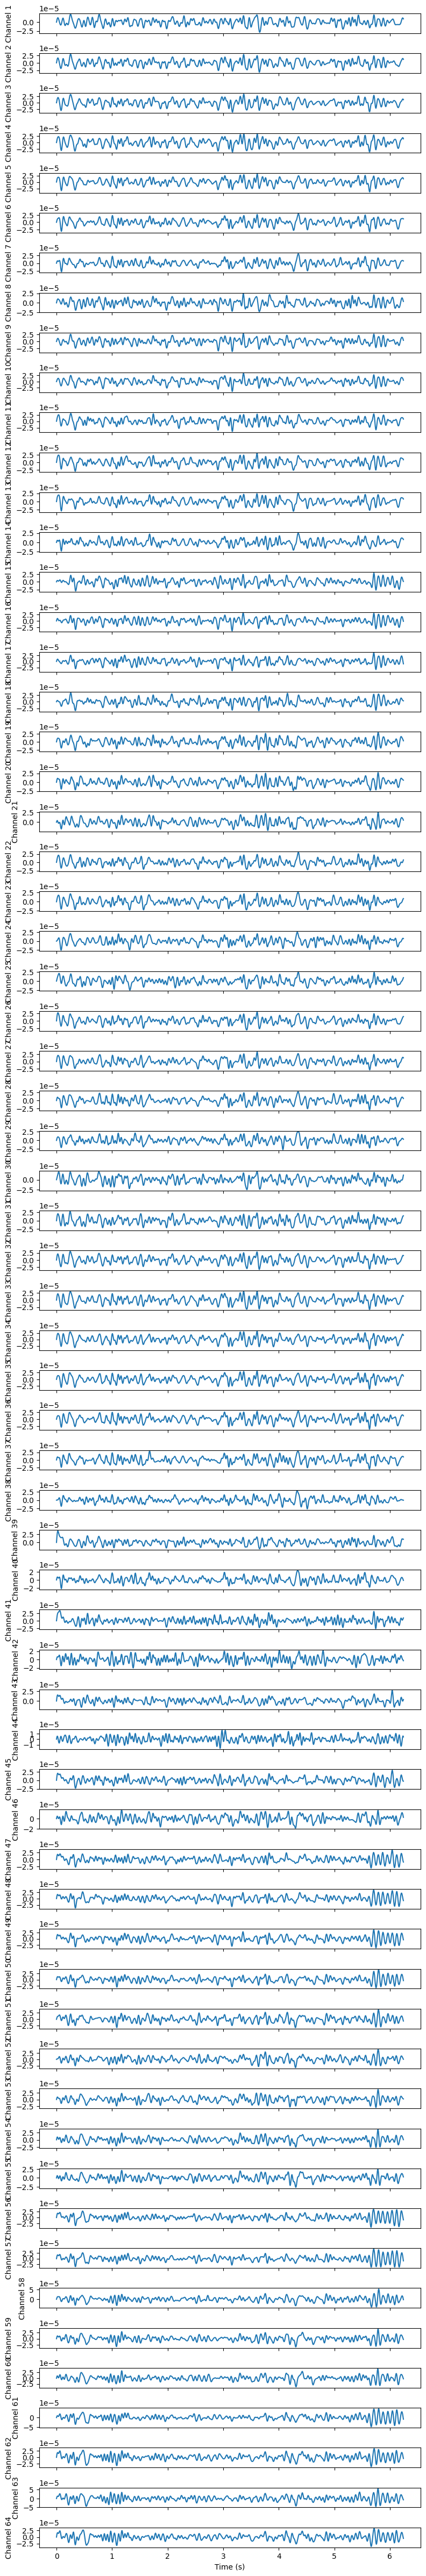

In [10]:
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
import mne
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
"""
  * @author: dengyufeng
  * @Created on 2024/8/14 11:31
 """
def batch_process():
    # 弹出文件选择对话框，允许用户选择多个文件
    file_paths = filedialog.askopenfilenames(filetypes=[("All files", "*.*"), ("FIF files", "*.fif"), ("EDF files", "*.edf"), ("BDF files", "*.bdf")])
    
    if not file_paths:
        return

    # 处理每个文件
    for file_path in file_paths:
        try:
            # 根据选择的文件格式加载数据
            if file_path.endswith('.fif'):
                raw_data = mne.io.read_raw_fif(file_path, preload=True)
            elif file_path.endswith('.edf'):
                raw_data = mne.io.read_raw_edf(file_path, preload=True)
            elif file_path.endswith('.bdf'):
                raw_data = mne.io.read_raw_bdf(file_path, preload=True)
            else:
                messagebox.showerror("错误", f"不支持的文件格式: {file_path}")
                continue

            # 执行数据处理
            process_data.raw = raw_data  # 使用现有的处理逻辑

            # 执行数据处理
            process_data()

            # 你可以在这里选择是否保存处理后的数据或其他操作
            
            messagebox.showinfo("信息", f"数据文件处理完成: {file_path}")
        except Exception as e:
            messagebox.showerror("错误", f"处理数据文件失败: {file_path}\n{e}")

    messagebox.showinfo("信息", "批量处理完成。")

def process_data():
    if not hasattr(process_data, "raw"):
        messagebox.showerror("错误", "请先加载数据。")
        return

    try:
        # 获取用户输入的滤波参数
        notch_freq = int(notch_freq_entry.get())
        l_freq = float(l_freq_entry.get())
        h_freq = float(h_freq_entry.get())
        ref_type = ref_var.get()
        ref_channel = ref_channel_var.get()

        print(f"Notch Frequency: {notch_freq}")
        print(f"Low Frequency: {l_freq}")
        print(f"High Frequency: {h_freq}")
        print(f"Reference Type: {ref_type}")
        print(f"Reference Channel: {ref_channel}")

        # 工频滤波
        process_data.raw.notch_filter(freqs=notch_freq)

        # 带通滤波
        process_data.raw.filter(l_freq=l_freq, h_freq=h_freq)

        # 设置参考
        if ref_type == '平均参考':
            process_data.raw.set_eeg_reference('average', projection=True)
        elif ref_type == '单通道参考':
            if ref_channel:
                process_data.raw.set_eeg_reference(ref_channel, projection=True)
            else:
                messagebox.showerror("错误", "请先选择参考通道。")
                return

        # 显示数据
        plot_data()
        messagebox.showinfo("信息", "数据处理成功。")

        # 更新按钮布局
        update_button_layout()

    except ValueError as e:
        messagebox.showerror("错误", f"输入参数错误: {e}")
    except Exception as e:
        messagebox.showerror("错误", f"数据处理失败: {e}")

def update_button_layout():
    # 更新按钮布局
    process_button.grid(row=7, column=0, padx=10, pady=20)
    save_button.grid(row=7, column=1, padx=10, pady=20)

def load_data():
    # 获取用户选择的文件格式
    file_format = format_var.get()
    
    file_types = [("All files", "*.*")]
    if file_format == "FIF":
        file_types = [("FIF files", "*.fif"), ("All files", "*.*")]
    elif file_format == "EDF":
        file_types = [("EDF files", "*.edf"), ("All files", "*.*")]
    elif file_format == "BDF":
        file_types = [("BDF files", "*.bdf"), ("All files", "*.*")]

    file_path = filedialog.askopenfilename(filetypes=file_types)
    
    if file_path:
        try:
            if file_format == "FIF":
                process_data.raw = mne.io.read_raw_fif(file_path, preload=True)
            elif file_format == "EDF":
                process_data.raw = mne.io.read_raw_edf(file_path, preload=True)
            elif file_format == "BDF":
                process_data.raw = mne.io.read_raw_bdf(file_path, preload=True)
            else:
                messagebox.showerror("错误", "请选择一个支持的文件格式。")
                return

            update_channel_list()
            messagebox.showinfo("信息", "数据加载成功。")
        except Exception as e:
            messagebox.showerror("错误", f"数据加载失败: {e}")

# 更新通道列表
def update_channel_list():
    if hasattr(process_data, "raw"):
        channel_names = process_data.raw.info['ch_names']
        ref_channel_menu['values'] = channel_names
        ref_channel_menu.set('')  # 清空选择

# 显示EEG数据
def plot_data():
    if hasattr(process_data, "raw"):
        print("Plotting data...")

        # 提取数据和时间
        data, times = process_data.raw[:, :1000]  # 获取所有通道和前1000个时间点的数据
        
        # 创建图形
        num_channels = data.shape[0]
        fig, axs = plt.subplots(num_channels, 1, figsize=(8, 0.75 * num_channels), sharex=True)  # 调整figsize参数
        
        if num_channels == 1:
            axs = [axs]  # 如果只有一个通道，axs 是一个单一的 Axes 对象，需要转为列表

        for i in range(num_channels):
            axs[i].plot(times, data[i])  # 移除μV转换，直接使用数据
            axs[i].set_ylabel(f'Channel {i+1}')
        
        axs[-1].set_xlabel('Time (s)')
        fig.tight_layout(pad=1.0)  # 调整子图布局，以防标签重叠，并减小子图之间的间距

        # 嵌入到 tkinter 窗口中
        for widget in root.grid_slaves(row=9, column=0):
            widget.destroy()
        
        canvas = FigureCanvasTkAgg(fig, master=root)
        canvas.draw()
        canvas.get_tk_widget().grid(row=9, column=0, columnspan=3, pady=20)
    else:
        messagebox.showerror("错误", "请先加载数据。")

def save_data():
    if not hasattr(process_data, "raw"):
        messagebox.showerror("错误", "请先加载和处理数据。")
        return

    # 弹出文件保存对话框
    file_path = filedialog.asksaveasfilename(defaultextension=".fif", filetypes=[("FIF files", "*.fif"), ("All files", "*.*")])
    
    if file_path:
        try:
            # 保存处理后的数据
            process_data.raw.save(file_path, overwrite=True)
            messagebox.showinfo("信息", f"数据保存成功: {file_path}")
        except Exception as e:
            messagebox.showerror("错误", f"数据保存失败: {e}")

def close_window():
    root.destroy()

# 创建主窗口
root = tk.Tk()
root.title("EEG 数据处理")

# 关闭按钮
close_button = tk.Button(root, text="关闭", command=close_window)
close_button.grid(row=0, column=2, padx=10, pady=10, sticky=tk.E)

# 文件格式选择标签
tk.Label(root, text="选择文件格式:").grid(row=0, column=0, padx=10, pady=10)
format_var = tk.StringVar(value='FIF')
format_menu = ttk.Combobox(root, textvariable=format_var, values=["FIF", "EDF", "BDF"])
format_menu.grid(row=0, column=1, padx=10, pady=10)

# 加载数据按钮
load_button = tk.Button(root, text="加载数据", command=load_data)
load_button.grid(row=1, column=0, columnspan=2, pady=20)

# 工频滤波频率
tk.Label(root, text="工频滤波频率 (Hz):").grid(row=2, column=0, padx=10, pady=10)
notch_freq_entry = tk.Entry(root)
notch_freq_entry.grid(row=2, column=1, padx=10, pady=10)

# 带通滤波下限
tk.Label(root, text="带通滤波下限 (Hz):").grid(row=3, column=0, padx=10, pady=10)
l_freq_entry = tk.Entry(root)
l_freq_entry.grid(row=3, column=1, padx=10, pady=10)

# 带通滤波上限
tk.Label(root, text="带通滤波上限 (Hz):").grid(row=4, column=0, padx=10, pady=10)
h_freq_entry = tk.Entry(root)
h_freq_entry.grid(row=4, column=1, padx=10, pady=10)

# 参考类型
tk.Label(root, text="参考类型:").grid(row=5, column=0, padx=10, pady=10)
ref_var = tk.StringVar(value='平均参考')
ttk.Radiobutton(root, text='平均参考', variable=ref_var, value='平均参考', command=lambda: ref_channel_menu.grid_forget()).grid(row=5, column=1, padx=10, pady=10, sticky=tk.W)
ttk.Radiobutton(root, text='单通道参考', variable=ref_var, value='单通道参考', command=lambda: ref_channel_menu.grid(row=6, column=1, padx=10, pady=10)).grid(row=5, column=1, padx=10, pady=10, sticky=tk.E)

# 单通道参考通道选择
tk.Label(root, text="选择参考通道:").grid(row=6, column=0, padx=10, pady=10)
ref_channel_var = tk.StringVar()
ref_channel_menu = ttk.Combobox(root, textvariable=ref_channel_var)
ref_channel_menu.grid(row=6, column=1, padx=10, pady=10)
ref_channel_menu.grid_forget()  # 初始时隐藏下拉菜单

# 处理按钮
process_button = tk.Button(root, text="处理数据", command=process_data)
process_button.grid(row=7, column=0, padx=10, pady=20)

# 保存按钮
save_button = tk.Button(root, text="保存数据", command=save_data)
save_button.grid(row=7, column=1, padx=10, pady=20)

# 批量处理按钮
batch_button = tk.Button(root, text="批量处理", command=batch_process)
batch_button.grid(row=8, column=0, columnspan=3, pady=20)

root.mainloop()
